# Training Dataset Summary_Occurrence EDA
The dataset is a subset of the GBIF occurrence dataset which combines data from a wide array of sources, including specimen-related data from natural history museums, observations from citizen science networks, and automated environmental surveys. For our purposes, we are only interested in a narrow subset of the data relating to 9 selected frog species from Australia, Costa Rica, and South Africa. To improve the representation of some frog species, we have expanded the dataset to include some neighbouring countries in Central America and Africa, however your model will be tested on set regions in Australia, Costa Rica, and South Africa. 
**Try to explore the spatial distribution of all frogs, and get 8000 training data pts**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from itertools import cycle
import contextily as cx
import warnings
import zipfile
import os
import geopandas
data_path = '../'
output_path = './output/'
warnings.filterwarnings("ignore")

### Read in data

In [34]:
columns = [
    'gbifID','eventDate','country','continent','stateProvince',
    'decimalLatitude','decimalLongitude','species', 'coordinateUncertaintyInMeters'
]

country_names = {
    'AU':'Australia','CR':'Costa Rica', 'ZA':'South Africa','MX':'Mexico','HN':'Honduras',
    'MZ':'Mozambique','BW':'Botswana','MW':'Malawi','CO':'Colombia','PA':'Panama','NI':'Nicaragua',
    'BZ':'Belize','ZW':'Zimbabwe','SZ':'Eswatini','ZM':'Zambia','GT':'Guatemala','LS':'Lesotho',
    'SV':'El Salvador', 'AO':'Angola', np.nan:'unknown or invalid'
}

continent_names = {
    'AU':'Australia', 'CR':'Central America', 'ZA':'Africa','MX':'Central America','HN':'Central America',
    'MZ':'Africa','BW':'Africa','MW':'Africa','CO':'Central America','PA':'Central America',
    'NI':'Central America','BZ':'Central America','ZW':'Africa','SZ':'Africa','ZM':'Africa',
    'GT':'Central America','LS':'Africa','SV':'Central America','AO':'Africa', np.nan:'unknown or invalid' 
}
    
data = (
    pd.read_csv('occurrence.txt', sep='\t', parse_dates=['eventDate'])
    .assign(
        country =  lambda x: x.countryCode.map(country_names),
        continent =  lambda x: x.countryCode.map(continent_names),
        species = lambda x: x.species.str.title()
    )    
    # Rename ranoidea australis to cyclorana australis
    .assign(species = lambda x: np.where(x.species == 'Ranoidea Australis', 'Cyclorana Australis', x.species))
    [columns]
)
# Only care about Australia
data = data[data['country'] == 'Australia']
np.sum(data.isna())/len(data)*100

gbifID                           0.000000
eventDate                        4.427720
country                          0.000000
continent                        0.000000
stateProvince                    0.013296
decimalLatitude                  0.000000
decimalLongitude                 0.000000
species                          0.000000
coordinateUncertaintyInMeters    7.965642
dtype: float64

In [35]:
data.to_csv('occurrence_raw.csv')

### See what the data look like & drop stuff

In [3]:
# There are 126657 target frog occurrence, 366 of them has no date, 1455 of them has no coordinate Uncertainty in Meters
# Top 2 species: Crinia Signifera   110267, Litoria Fallax    45629, only care about these 2
data = pd.read_csv('occurrence_raw.csv',parse_dates=['eventDate']).dropna()
data = data[(data['species']== 'Litoria Fallax') | (data['species']== 'Crinia Signifera')]

# since some data is too early, only take things after 2010
data = data[lambda x: (x.eventDate.dt.year >= 2010) ]
print(data.shape)
data.describe()

(107996, 10)


Unnamed: 0        gbifID  decimalLatitude  decimalLongitude  \
count  107996.000000  1.079960e+05    107996.000000     107996.000000   
mean    76453.431034  3.117523e+09       -33.709512        149.497380   
std     52567.680361  6.317213e+08         3.574783          3.357696   
min         4.000000  3.320324e+08       -43.609343        135.274000   
25%     34090.750000  3.108874e+09       -35.415100        148.277000   
50%     64821.500000  3.463509e+09       -33.835933        150.867075   
75%    111876.000000  3.463623e+09       -33.110863        151.365000   
max    193533.000000  3.469063e+09       -16.066700        153.630000   

       coordinateUncertaintyInMeters  
count                   1.079960e+05  
mean                    4.153834e+02  
std                     4.893240e+03  
min                     1.000000e+00  
25%                     5.000000e+00  
50%                     1.214000e+01  
75%                     9.840000e+01  
max                     1.445600e+06

In [170]:
data.groupby('species').describe()

Unnamed: 0                                             \
                      count          mean           std   min      25%   
species                                                                  
Crinia Signifera    71413.0  72368.569210  51101.139477  16.0  32290.0   
Litoria Fallax      36583.0  84427.414509  54443.224740   4.0  38461.5   

                                                gbifID                ...  \
                      50%       75%       max    count          mean  ...   
species                                                               ...   
Crinia Signifera  60724.0  101771.0  193487.0  71413.0  3.147493e+09  ...   
Litoria Fallax    75106.0  126092.0  193533.0  36583.0  3.059021e+09  ...   

                 decimalLongitude             coordinateUncertaintyInMeters  \
                              75%         max                         count   
species                                                                       
Crinia Signifera       151.082931  153.630000                       71413.0   
Litoria Fallax         152.747000  153.624262                       36583.0   

                                                                               
                        mean          std  min   25%    50%    75%        max  
species                                                                        
Crinia Signifera  418.793535  5747.898208  1.0  5.00  10.00   65.0  1445600.0  
Litoria Fallax    408.726576  2488.145844  1.0  7.39  23.75  100.0    79131.0  

[2 rows x 40 columns]

**对于uncertanty来说，median是23，mean是408，显然skewed to right，所以太不确定的就放弃，这里尝试drop各自75% 不确定以上的**

In [4]:
data = data[((data['species']== 'Litoria Fallax') & (data['coordinateUncertaintyInMeters'] <= 100)) | (( data['species']== 'Crinia Signifera') & (data['coordinateUncertaintyInMeters'] <= 65)) ]
data.groupby('species').count()

Unnamed: 0  gbifID  eventDate  country  continent  \
species                                                               
Crinia Signifera       55198   55198      55198    55198      55198   
Litoria Fallax         32032   32032      32032    32032      32032   

                  stateProvince  decimalLatitude  decimalLongitude  \
species                                                              
Crinia Signifera          55198            55198             55198   
Litoria Fallax            32032            32032             32032   

                  coordinateUncertaintyInMeters  
species                                          
Crinia Signifera                          55198  
Litoria Fallax                            32032

### Spatial Distribution
**现在是2010-2022年，LF品种: Uncertainty小于100，澳大利亚地区的occurrence，共有32032个**

**CS 品种;uncertainty小于65， 55198个，无null**

In [4]:
species_colourmap = {species:colour['color'] for species, colour in zip(data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
def plot_species(fig, ax, frog_data, region_name, colourmap=None):
    # Bar chart
    bar_data = frog_data.species.value_counts()
    barchart = ax[1].bar(bar_data.index.str.replace(' ', '\n'), bar_data)
    # Colour cycle to ensure colors match in both plots
    if colourmap is None:
        colourmap = {species:colour['color'] for species, colour in zip(frog_data.species.value_counts().index, cycle(plt.rcParams['axes.prop_cycle']))}
    for i in range(len(bar_data)):
        species_name = bar_data.index[i]
        if len(species_name) > 19:
            display_name = species_name.replace(' ', '\n')
        else:
            display_name = species_name
        barchart[i].set_color(colourmap[species_name])
        barchart[i].set_label(f"{display_name}\nCount: {bar_data[i]}")
        filt = frog_data.species == species_name
        # Scatter plot
        ax[0].scatter(
            frog_data[filt].decimalLongitude, 
            frog_data[filt].decimalLatitude, 
            marker='.', 
            color=colourmap[species_name]
        )
    # Add other features
    ax[0].set_title(f"Frog occurrences for {region_name}")
    ax[0].set_xticklabels([])
    ax[0].set_yticklabels([])
    ax[1].set_title(f"Frog species distribution in {region_name}")
    cx.add_basemap(ax[0], crs={'init':'epsg:4326'}, alpha=0.5) # Add basemap
    ax[1].set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax[1].legend()
    
def plot_barchart(bar_data, ax, colourmap=None, bar_params={}):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    if colourmap is None:
        prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
        colourmap = {spec:col['color'] for spec, col in zip(bar_data.index, prop_cycle)}
    for i in range(len(bar_data)):
        var_name = bar_data.index[i]
        barchart[i].set_color(colourmap[var_name])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

C:\Users\liuyi\AppData\Local\Temp\ipykernel_49588\2776781270.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)


Text(0.5, 1.0, 'CS Frog occurrences by stateProvince')

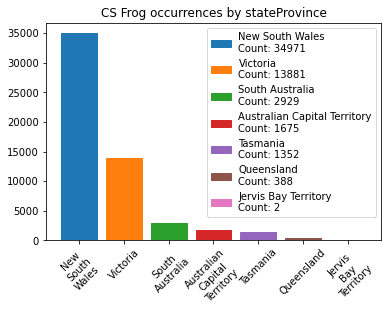

In [5]:
stateProvince_bar_data = data[data['species']=='Crinia Signifera'].stateProvince.value_counts()
fig, ax = plt.subplots()
plot_barchart(stateProvince_bar_data, ax)
ax.set_title('CS Frog occurrences by stateProvince')

Text(0.5, 1.0, 'LF Frog occurrences by stateProvince')

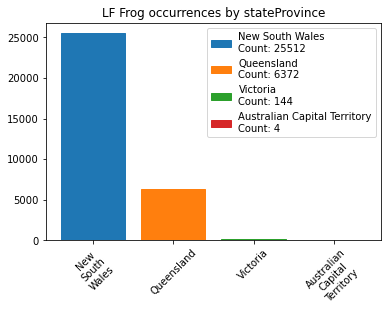

In [198]:
stateProvince_bar_data = data[data['species']=='Litoria Fallax'].stateProvince.value_counts()
fig, ax = plt.subplots()
plot_barchart(stateProvince_bar_data, ax)
ax.set_title('LF Frog occurrences by stateProvince')

HTTPError: Tile URL resulted in a 404 error. Double-check your tile url:
https://stamen-tiles-a.a.ssl.fastly.net/terrain/17/120406/79221.png

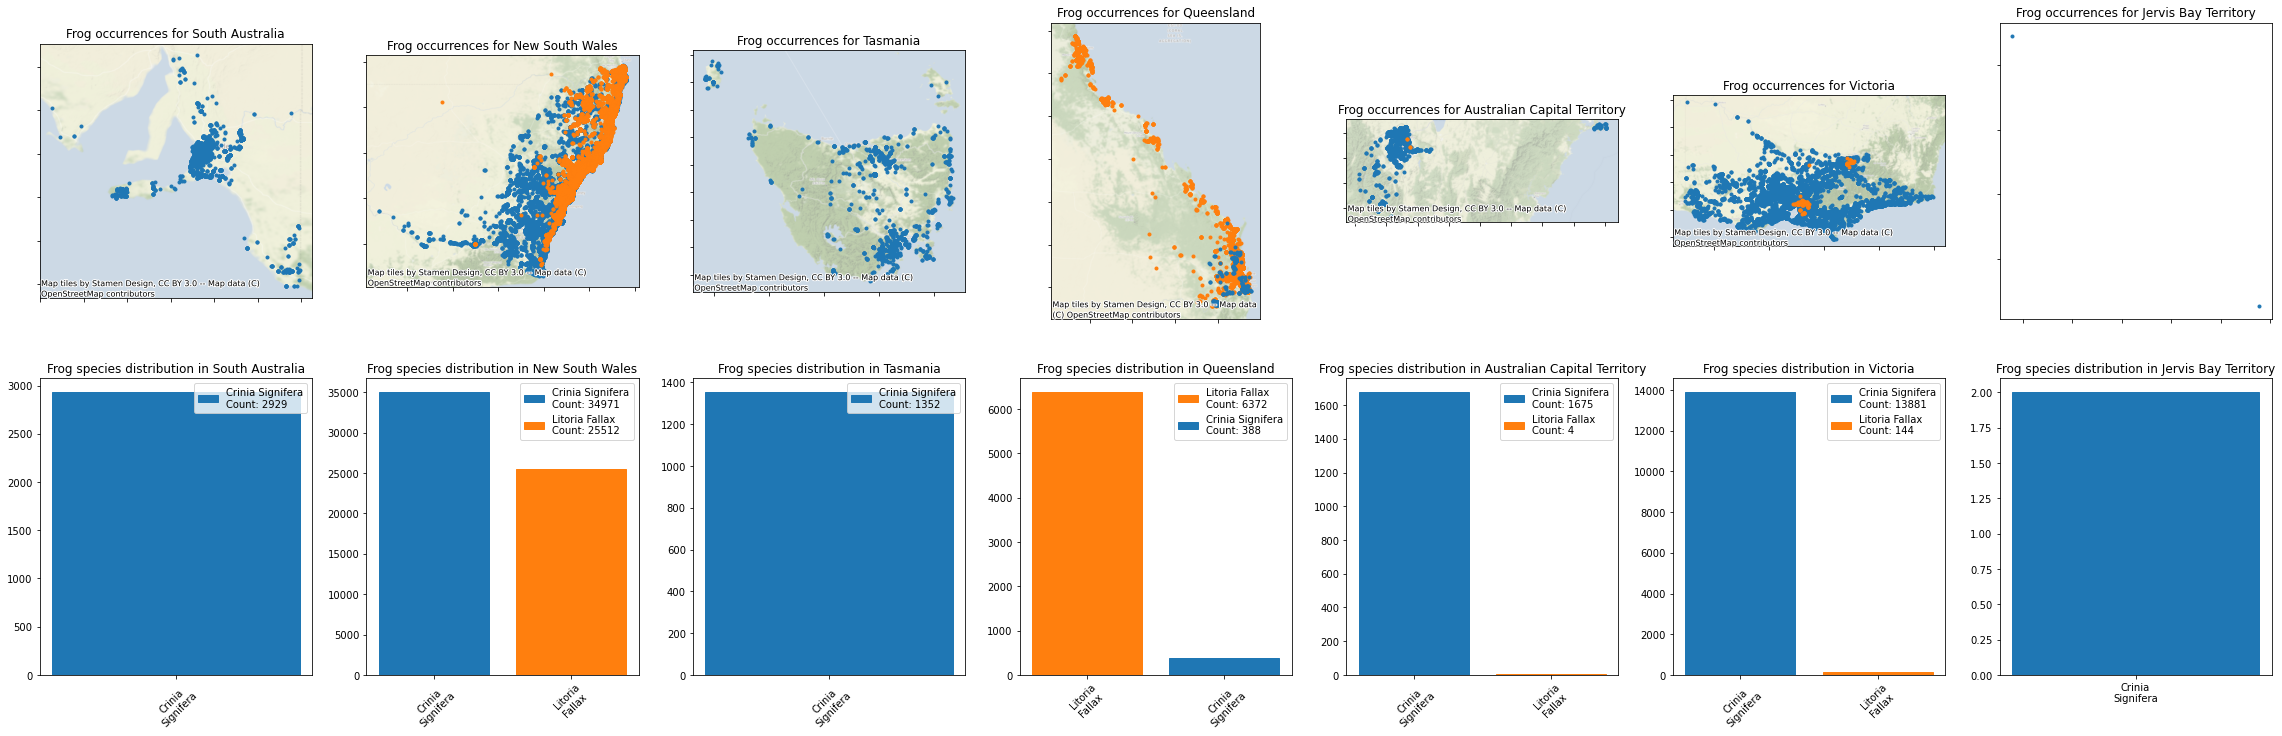

In [23]:
fig, ax = plt.subplots(2, 7, figsize=(40,12))
for i, cnt in enumerate(data.stateProvince.unique()):
    filt = data.stateProvince == cnt
    plot_species(fig, ax[:, i], data[filt], cnt, colourmap=species_colourmap)
plt.show()

**遇到了一些问题，这里或许跟pseudo absence有关，之后再说，先继续往下看spatial和temporal**

To assist in exploring the data, below we have defined an interactive map using the folium package. 

In [14]:
# Plotting functions
def plotDot(point, folium_map, species_colours):
    folium.CircleMarker(
        location=[point.decimalLatitude, point.decimalLongitude],
        radius=10,
        stroke=False,
        weight=5,
        fill=True,
        fillOpacity=1.0,
        opacity=1.0,
        color=species_colours[point.species]
    ).add_to(folium_map)
    
#create a map
frog_map = folium.Map(prefer_canvas=True)

# plot 1000 points from each country
(data[data.country == 'Australia']).sample(10000, random_state=420).apply(plotDot, axis = 1, args=(frog_map, species_colourmap))
 
#Set the zoom to the maximum possible
frog_map.fit_bounds(frog_map.get_bounds())
#Lat lon on click
frog_map.add_child(folium.LatLngPopup())
#Save the map to an HTML file
# frog_map.save(output_path+'frog_map_training.html')
frog_map.save('frog_map_training.html')
frog_map

## Temporal Distribution

Another aspect of the dataset that might be worth exploring is the temporal component. When building your models, you should consider whether older observations are relevant to pair with newer satellite data. We plot the occurrences over time below.

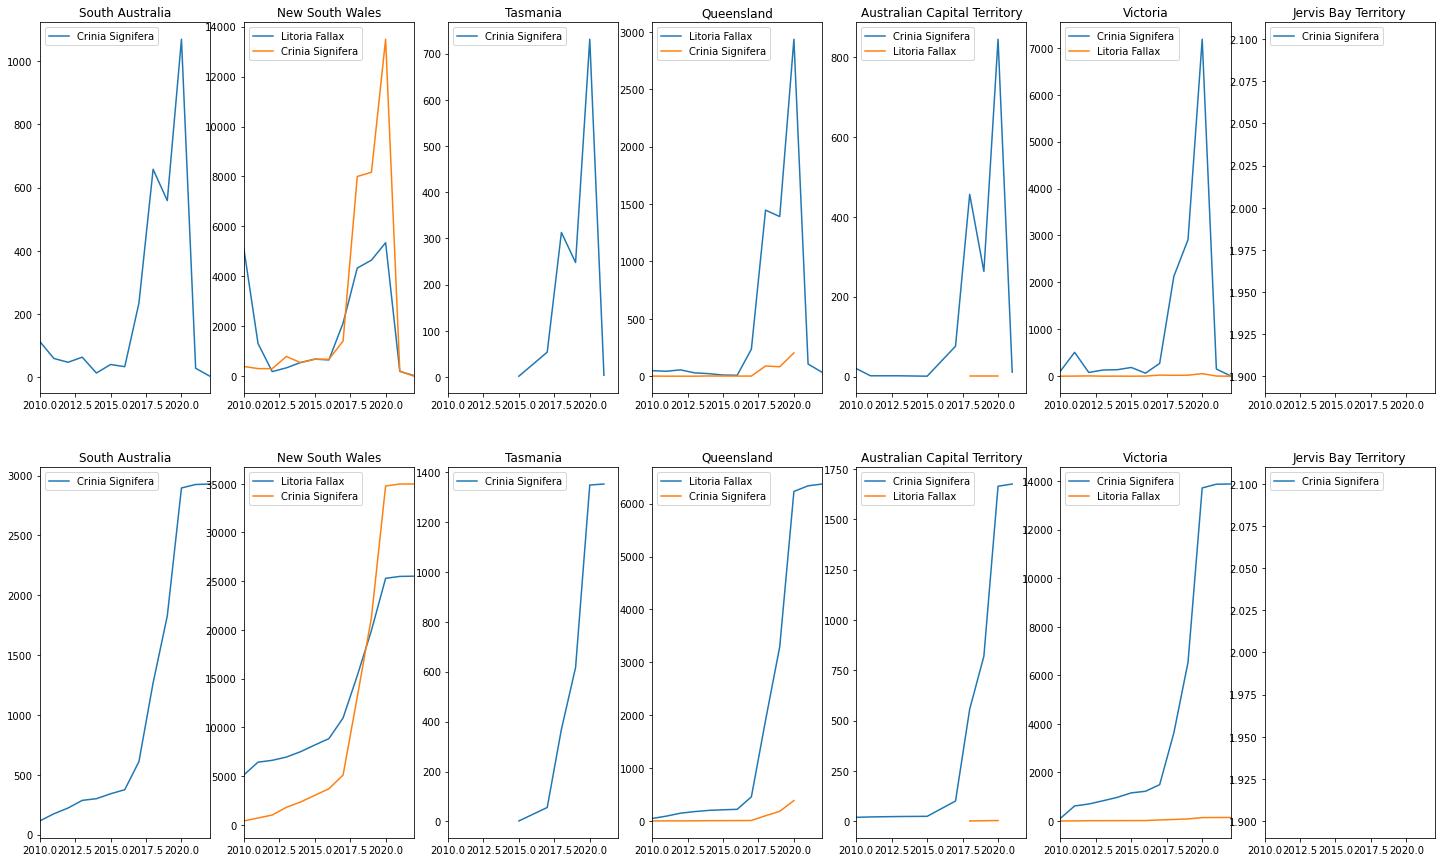

In [16]:
fig, ax = plt.subplots(2, 7, figsize=(25, 15))

for i, cnt in enumerate(data.stateProvince.unique()):
    country_data = data[data.stateProvince == cnt]    
    for species in country_data.species.unique():
        plot_data = country_data[lambda x: x.species == species]
        line_data = (
            plot_data[['eventDate']].dropna().assign(year = lambda x: x.eventDate.dt.year,n = 1)
            .groupby('year')
            .sum()
            .reset_index()
            .sort_values('year')
            .assign(ncum=lambda x: x.n.cumsum())
        )
        ax[1, i].plot(line_data.year, line_data.ncum, label=species)
        ax[0, i].plot(line_data.year, line_data.n, label=species)
        #ax[0, i].hist(plot_data.eventDate.dt.year, alpha=0.5, label=species, density=True, bins=list(range(2000, 2022, 2)))
    xlim = (2010, 2022)
    # xlim = (country_data.eventDate.dt.year.min(), country_data.eventDate.dt.year.max()) 
    ax[1, i].legend(loc='upper left')
    ax[1, i].set_xlim(xlim)
    ax[1, i].set_title(f"{cnt}")
    ax[0, i].legend(loc='upper left')
    ax[0, i].set_xlim(xlim)
    ax[0, i].set_title(f"{cnt}")


**Up till now, we decide to use all above data for generalizing final train& test df. We will now explore terraclimate data on these regions: New South Wales, Queensland, Victoria**

In [1]:
# Read in terraclimate data for 11 vars and all regions


**Since we don't have climate data for 21 and 22, drop these for occurrence and do class balancing**

In [8]:
data = data[lambda x: (x.eventDate.dt.year < 2021) ]
target_species = 'Litoria Fallax'
all_frog_data = (
    data
    # Assign the occurrenceStatus to 1 for the target species and 0 for all other species.
    # as well as a key for joining (later)
    .assign(
        occurrenceStatus = lambda x: np.where(x.species == target_species, 1, 0)
    )
)
all_frog_data.groupby('species').count()

Unnamed: 0  gbifID  eventDate  country  continent  \
species                                                               
Crinia Signifera       54785   54785      54785    54785      54785   
Litoria Fallax         31666   31666      31666    31666      31666   

                  stateProvince  decimalLatitude  decimalLongitude  \
species                                                              
Crinia Signifera          54785            54785             54785   
Litoria Fallax            31666            31666             31666   

                  coordinateUncertaintyInMeters  occurrenceStatus  
species                                                            
Crinia Signifera                          54785             54785  
Litoria Fallax                            31666             31666

Text(0.5, 1.0, 'Balanced training set')

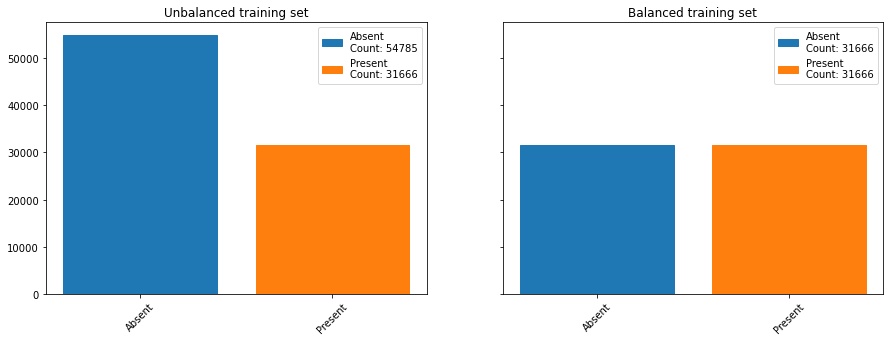

In [10]:
target_species_frog_data = all_frog_data[all_frog_data.occurrenceStatus == 1]
frog_data = (
    all_frog_data
    [lambda x: x.occurrenceStatus == 0]
    .sample(
        len(target_species_frog_data), random_state=420, replace=True
    )
    .append(target_species_frog_data)
    # assign key for joining purposes
    .reset_index(drop=True)
    .assign(key=lambda x: x.index)
)
# Bar charts
def plot_barchart(bar_data, ax, bar_params={}, fold_text=True):
    barchart = ax.bar(bar_data.index, bar_data, **bar_params)
    prop_cycle = cycle(plt.rcParams['axes.prop_cycle'])
    for i, color in zip(range(len(bar_data)), prop_cycle):
        var_name = bar_data.index[i]
        barchart[i].set_color(color['color'])
        barchart[i].set_label(f"{var_name}\nCount: {bar_data[i]}")
    ax.set_xticklabels(bar_data.index.str.replace(' ', '\n'), rotation=45)
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey=True, sharex=True)
bar_data = all_frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(bar_data, ax[0], bar_params={})
ax[0].set_title('Unbalanced training set')
balanced_bar_data = frog_data.occurrenceStatus.map({1:'Present', 0:'Absent'}).value_counts()
plot_barchart(balanced_bar_data, ax[1], bar_params={})
ax[1].set_title('Balanced training set')

In [14]:
frog_data.to_csv('30kfrogs.csv')